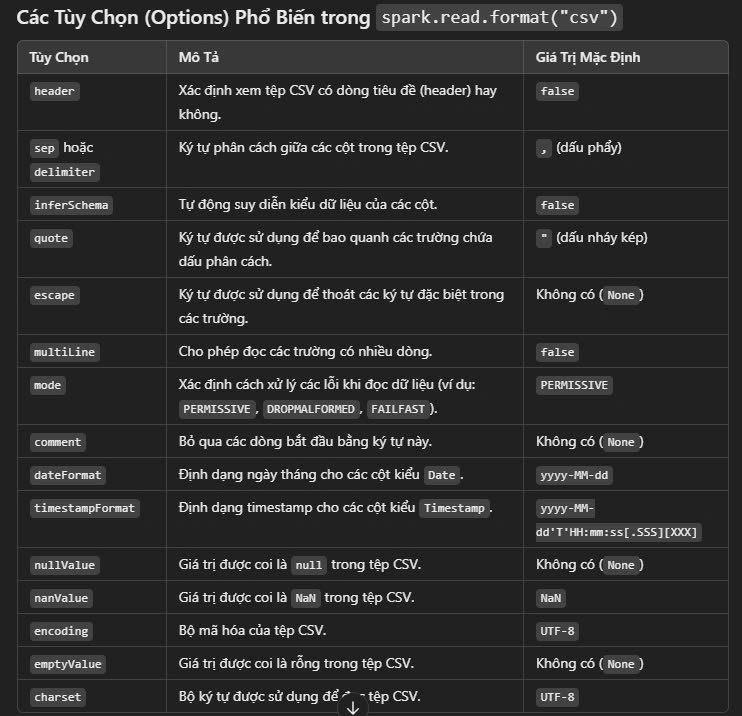


In [38]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame
from pyspark.rdd import RDD
from pyspark.sql.types import Row

sc = SparkSession.builder \
    .appName("Email Data Processing") \
    .getOrCreate()

dataPath = "./email.csv"

In [39]:
dataPath = os.environ.get("DATA_MIDTERM") or dataPath

In [40]:
#0.5
def loadAndProcessCsv(filePath: str, spark: SparkSession) -> DataFrame:
    '''
    This function loads a CSV file into a Spark DataFrame, caches it, 
    drops rows with null values, and prints the schema. (using option when read to keep format - header, columns)
    
    Args:
        file_path (str): Path to the CSV file.
        spark (SparkSession): Active Spark session.
        
    Returns:
        DataFrame: Processed DataFrame.
    '''

    data = None
    # YOUR CODE HERE
    data = spark.read.format("csv").option("header", "true").option("sep", ",").option("quote", "\"").option("escape", "\"").option("multiLine", "true").option("inferSchema", "true").load(filePath)
    data.cache()
    data = data.dropna()
    data.printSchema()
    
    return data

In [41]:
data = loadAndProcessCsv(dataPath,sc)

root
 |-- file: string (nullable = true)
 |-- message: string (nullable = true)



In [42]:
data.columns

['file', 'message']

In [43]:
data.show(10)

+--------------------+--------------------+
|                file|             message|
+--------------------+--------------------+
|  jones-t/sent/5567.|Message-ID: <1162...|
|hayslett-r/all_do...|Message-ID: <1139...|
|taylor-m/all_docu...|Message-ID: <2837...|
|lavorato-j/delete...|Message-ID: <3090...|
|farmer-d/logistic...|Message-ID: <2344...|
|donohoe-t/all_doc...|Message-ID: <2090...|
|gang-l/deleted_it...|Message-ID: <2583...|
|guzman-m/discussi...|Message-ID: <1170...|
|kean-s/all_docume...|Message-ID: <1471...|
|meyers-a/deleted_...|Message-ID: <2596...|
+--------------------+--------------------+
only showing top 10 rows



In [44]:
# 0.5đ
def createRDD(data: DataFrame)->RDD[Row]:
    '''
    This function converts a Spark DataFrame into an RDD of Rows.
    
    Args:
        data (DataFrame): Input DataFrame containing data loaded by Spark.
        
    Returns:
        RDD[Row]: An RDD containing all Rows from the input DataFrame.
    '''
    outRDD = None

    # YOUR CODE HERE
    outRDD = data.rdd
    
    return outRDD

In [45]:
emailRDD = createRDD(data)
assert isinstance(emailRDD, RDD), "createRDD() does not return the correct data type (RDD)"
assert isinstance(emailRDD.first(),Row), "createRDD() contains elements that are not of type Row"

In [46]:
emailRDD.first()

Row(file='jones-t/sent/5567.', message="Message-ID: <11629296.1075847544895.JavaMail.evans@thyme>\nDate: Thu, 1 Feb 2001 08:00:00 -0800 (PST)\nFrom: tana.jones@enron.com\nTo: bob.bowen@enron.com, laurel.adams@enron.com, andrea.guillen@enron.com, \n\tlarry.hunter@enron.com, gordon.heaney@enron.com, \n\tjanie.aguayo@enron.com, derek.bailey@enron.com, \n\tdiane.anderson@enron.com, kevin.meredith@enron.com, \n\tscott.tackett@enron.com, celeste.cisneros@enron.com, \n\ttiffany.williams@enron.com, kim.theriot@enron.com, \n\tdianne.seib@enron.com, melissa.murphy@enron.com, \n\twilliam.bradford@enron.com, debbie.brackett@enron.com, \n\ttanya.rohauer@enron.com, brant.reves@enron.com, tracy.ngo@enron.com, \n\tlesli.campbell@enron.com, veronica.espinoza@enron.com, \n\tpaul.radous@enron.com, wendi.lebrocq@enron.com, \n\trussell.diamond@enron.com, tom.moran@enron.com, \n\tedward.sacks@enron.com, nidia.mendoza@enron.com, \n\tbradley.diebner@enron.com, wendy.conwell@enron.com, \n\tdarren.vanek@enron.c

In [47]:
import email
from typing import List, Optional
from pyspark.sql.types import Row

def splitEmailAddresses(emailString: str) -> List[Optional[str]]:
    '''
    The function splits a comma-separated string of email addresses into a unique list.
    
    Args:
        emailString: A string containing email addresses separated by commas.
        
    Returns:
        A list of unique email addresses.
    '''
    if emailString:
        addresses = emailString.split(',')
        uniqueAddresses = list(frozenset(map(lambda x: x.strip(), addresses)))
        return uniqueAddresses
    return []

def extractEmailDetailsFromRawText(rawEmail: str) -> Row:
    '''
    The function extracts relevant details from a raw email message string.
    
    Args:
        rawEmail: A string representing the raw email message.
        
    Returns:
        A Row object containing the extracted email details.
    '''
    emailMessage = email.message_from_string(rawEmail)
    emailContentParts = []
    for part in emailMessage.walk():
        if part.get_content_type() == 'text/plain':
            emailContentParts.append(part.get_payload())

    emailContent = ''.join(emailContentParts)

    fromAddresses = splitEmailAddresses(emailMessage.get("From"))
    toAddresses = splitEmailAddresses(emailMessage.get("To"))
    ccEmail = splitEmailAddresses(emailMessage.get("Cc"))
    return Row(
        Date=emailMessage.get("Date"),
        From=fromAddresses, 
        To=toAddresses, 
        Subject=emailMessage.get("Subject"), 
        CC=ccEmail, 
        Content=emailContent
    )

# Extract structured email details from the first email message
firstEmailData = data.first()
structuredEmail = extractEmailDetailsFromRawText(firstEmailData.message)
structuredEmail


Row(Date='Thu, 1 Feb 2001 08:00:00 -0800 (PST)', From=['tana.jones@enron.com'], To=['wendy.conwell@enron.com', 'tracy.ngo@enron.com', 'mark.taylor@enron.com', 'celeste.cisneros@enron.com', 'bernice.rodriguez@enron.com', 'carrie.southard@enron.com', 'laurel.adams@enron.com', 'gordon.heaney@enron.com', 'bob.bowen@enron.com', 'veronica.espinoza@enron.com', 'rudwell.johnson@enron.com', 'brent.hendry@enron.com', 'paul.radous@enron.com', 'larry.hunter@enron.com', 'adnan.patel@enron.com', 'wendi.lebrocq@enron.com', 'samantha.boyd@enron.com', 'edward.sacks@enron.com', 'anthony.campos@enron.com', 'samuel.schott@enron.com', 'lisa.lees@enron.com', 'lesli.campbell@enron.com', 'tom.moran@enron.com', 'russell.diamond@enron.com', 'dale.neuner@enron.com', 'tiffany.williams@enron.com', 'cheryl.nelson@enron.com', 'stephanie.panus@enron.com', 'brant.reves@enron.com', 'william.bradford@enron.com', 'diane.anderson@enron.com', 'diane.ellstrom@enron.com', 'stacey.richardson@enron.com', 'andrea.guillen@enron.

In [57]:
#0.5đ
def createStructuredEmailRDD(emailRDD: RDD[Row]) -> RDD[Row]:
    '''
    The function takes an RDD of email messages and converts it into a new RDD containing structured email details.
    
    Args:
        emailRDD: An RDD where each Row contains an email message in raw text format.
        
    Returns:
        A new RDD where each element is a Row with structured email details such as Date, From, To, Subject, CC, and Content.
    '''
    structuredEmailRDD = None
    # YOUR CODE HERE
    structuredEmailRDD = emailRDD.map(lambda x:extractEmailDetailsFromRawText(x.message))
    return structuredEmailRDD

In [58]:
structuredEmailRDD = createStructuredEmailRDD(emailRDD)
assert isinstance(structuredEmailRDD, RDD), "createStructuredEmailRDD() doesn't return an RDD"
assert isinstance(structuredEmailRDD.first(), Row), "createStructuredEmailRDD() elements are not of type Row"

In [63]:
#1.
def countNumberEmail(structuredEmailRDD: RDD[Row], k: int)->int:
    '''
    The function counts the number of emails with more than `k` email addresses in the 'To' field.
    
    Args:
    - structuredEmailRDD: RDD of Row objects, each containing an email's structured data.
    - k: The threshold for the number of emails in the 'To' field.
    
    Returns:
    - int: The count of emails with more than `k` email addresses in the 'To' field.
    '''
    count = -1
    # YOUR CODE HERE
    count = structuredEmailRDD.filter(lambda row: len(row['To']) > k).count()

    return count

In [64]:
countNumberEmail(structuredEmailRDD,40)

647

In [126]:

# 1đ
def countUniqueEmailDomains(structuredEmailRDD: RDD[Row], k) -> int:
    '''
    This function counts the number of unique email domains in the "CC" field using `map` and `reduce`.
    
    Args:
    - structuredEmailRDD: An RDD containing Row objects, each representing an email's structured data.
    
    Returns:
    - dict: A dictionary showing the count of emails from each unique domain in the "CC" field.
      Example:
        If k = 3, the result might look like:
        {
          'enron.com': 16452,
          'aol.com': 122,
          'hotmail.com': 101
        }
    '''
    results = {}
    # YOUR CODE HERE
    domainCounts = (
        structuredEmailRDD
        .flatMap(lambda row: [email.split('@')[1] for email in row.CC if email])  # Extract domains
        .map(lambda domain: (domain, 1))
        .reduceByKey(lambda a, b: a + b)
    )

    # Get the top k domains
    topKDomains = domainCounts.takeOrdered(k, key=lambda x: -x[1])
    result = dict(topKDomains)
    return result
    

In [127]:
countUniqueEmailDomains(structuredEmailRDD, 10)

{'enron.com': 18864,
 'aol.com': 92,
 'hotmail.com': 79,
 'duke-energy.com': 68,
 'haas.berkeley.edu': 50,
 'caiso.com': 47,
 'yahoo.com': 44,
 'enron.com>': 43,
 'iepa.com': 37,
 'akllp.com': 35}

In [128]:

# 0.5đ ;
def countEmailsBySubject(structuredEmailRDD: RDD[Row], subjectContent: str) -> int:
    '''
    The function count num emails the dataset to the subject have included "subjectContent", case insensitive

    Args:
    - structuredEmailRDD: RDD of Row objects containing an email's structured data.
    - subSubject: The content of the subject to filter by.

    Returns:
    - numEmails: Subject include content have substring subjectContent
    '''
    numEmails =  -1
    # YOUR CODE HERE
    numEmails = structuredEmailRDD.filter(
        lambda email: subjectContent.lower() in email.Subject.lower()
    ).count()
    return numEmails

In [129]:
countEmailsBySubject(structuredEmailRDD, "bank")

78

In [130]:

# 1.5d
def getTopKFrequentWordsInContentBySender(structuredEmailRDD: RDD[Row], sender: str, k: int) -> dict:
    '''
    This function filtered emails in the dataset sent by a specific sender's email,
    and then returns the top k most frequent words found in the content of those filtered emails.

    Args:
    - structuredEmailRDD: RDD of Row objects, where each Row represents an email with structured data, such as subject and content.
    - sender: sender's email which needs to count.
    - k: The number of most frequent words to return.

    Returns:
    - topKWordsDict: A dictionary containing the top k most frequent words found in the content of filtered emails.
                     The keys are the words, and the values are their frequencies, representing how often they appear in the content of the filtered emails.
                    example:
                    {'to': 12,
                     'the': 9,
                     'your': 8,
                     'a': 5,
                     'is': 4,
                     'survey': 4,
                     'and': 4,
                     'you': 4,
                     'of': 3,
                     'very': 3}
    '''
    topKWordsDict = {}
    # YOUR CODE HERE
    filteredEmailsRDD = structuredEmailRDD.filter(lambda email: sender in email.From)
    wordsRDD = filteredEmailsRDD.flatMap(lambda email: re.findall(r'\w+', email.Content.lower()))
    wordCounts = wordsRDD.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)
    topKWords = wordCounts.takeOrdered(k, key=lambda x: -x[1])
    topKWordsDict = dict(topKWords)
    return topKWordsDict

In [131]:
getTopKFrequentWordsInContentBySender(structuredEmailRDD, "tana.jones@enron.com", 10)

{'ect': 3392,
 'the': 1525,
 'hou': 1509,
 'to': 1353,
 'enron': 1332,
 'and': 719,
 'of': 657,
 'i': 566,
 'a': 554,
 'you': 505}

In [65]:
# SQL Query
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, size, to_date, year, month, weekofyear
sc.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# Convert RDD to DataFrame
dfEmais = structuredEmailRDD.toDF()
dfEmais = dfEmais.withColumn('DateTime', to_date(col('Date'), "EEE, d MMM yyyy HH:mm:ss Z"))
dfEmais = dfEmais.withColumn('Num_To', size(col('To')))
dfEmais = dfEmais.withColumn('Num_CC', size(col('CC')))

In [66]:
sqlContext = SQLContext(sc)
tableName = "Emails"
dfEmais.createOrReplaceTempView(tableName)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [69]:
# 0.5đ
def getTopKRowsBySQL(sqlContext: SQLContext, tableName: str, k: int) -> DataFrame:
    '''
    This function queries the first k rows from a given table using SQLContext.

    Args:
    - sqlContext: An SQLContext object that provides the environment to run SQL queries on structured data.
    - tableName: The name of the table from which the rows will be selected.
    - k: The number of rows to return. It must be a positive integer.

    Returns:
    - result: A DataFrame containing the first k rows of data from the specified table.
                If the table contains fewer than k rows, the DataFrame will contain all available rows.
    '''
    # YOUR CODE HERE
    result = sqlContext.sql(f'select * from {tableName} limit {k}')
    return result


def getTopKRowsByDFOperations(dataFrame: DataFrame, k: int) -> DataFrame:
    '''
    This function queries the first k rows from a given table using SQLContext.

    Args:
    - dataFrame: An DataFrame data
    - tableName: The name of the table from which the rows will be selected.
    - k: The number of rows to return. It must be a positive integer.

    Returns:
    - resultDF: A DataFrame containing the first k rows of data from the specified table.
                If the table contains fewer than k rows, the DataFrame will contain all available rows.
    '''
    # YOUR CODE HERE
    result = dataFrame.limit(k)
    return result

In [70]:
getTopKRowsBySQL(sqlContext,tableName,1).show()

+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+----------+------+------+
|                Date|                From|                  To|         Subject|                  CC|             Content|  DateTime|Num_To|Num_CC|
+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+----------+------+------+
|Thu, 1 Feb 2001 0...|[tana.jones@enron...|[carol.clair@enro...|Deutsche Bank AG|[larry.gagliardi@...|We have received ...|2001-02-01|    64|     3|
+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+----------+------+------+



In [72]:
getTopKRowsByDFOperations(dfEmais,3).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+------+------+
|                Date|                From|                  To|             Subject|                  CC|             Content|  DateTime|Num_To|Num_CC|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+------+------+
|Thu, 1 Feb 2001 0...|[tana.jones@enron...|[carol.clair@enro...|    Deutsche Bank AG|[larry.gagliardi@...|We have received ...|2001-02-01|    64|     3|
|Wed, 19 Jul 2000 ...|[patrick.cagney@e...|                  []|Report Council Mt...|[michael.sullivan...|Reporting Council...|2000-07-19|     0|     2|
|Fri, 3 Mar 2000 0...|[jenny.helton@enr...|[david.forster@en...|SO2 Enron EAuctio...|                  []|As promised by no...|2000-03-03|     5|     0|
+--------------------+--------------------+--------------------+------------------

In [77]:
# 1đ, 6.5đ
def countEmailsWithToGreaterThanKBySQL(sqlContext: SQLContext, tableName: str, k: int) -> int:
    '''
    This function uses SQL to count the number of emails with more than k email addresses in the To field.

    Args:
    - sqlContext: An SQLContext object that provides the environment to run SQL queries on structured data.
    - tableName: The name of the table that contains the email data.
    - k: The threshold number of email addresses in the To field.

    Returns:
    - count: An integer representing the number of emails where the To field has more than k email addresses.
    '''
    # YOUR CODE HERE
    count = sqlContext.sql(f'select count(*) from {tableName} where Num_To > {k}').collect()[0][0]
    return count
def countEmailsWithToGreaterThanKByDFOperations(dataFrame: DataFrame, k: int) -> int:
    '''
    This function counts the number of emails with more than k email addresses in the To field using DataFrame operations.

    Args:
    - dataFrame: A DataFrame containing the email data.
    - k: The threshold number of email addresses in the To field.

    Returns:
    - count: An integer representing the number of emails where the To field has more than k email addresses.
    '''
    # YOUR CODE HERE
    result = dataFrame.filter(dataFrame.Num_to > k).count()
    return result


In [76]:
countEmailsWithToGreaterThanKBySQL(sqlContext,tableName,50)

525

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
countEmailsWithMoreToThanCCInJanuaryBySQL(sqlContext, tableName)

In [ ]:
countEmailsWithMoreToThanCCInJanuaryByDFOperations(dfEmais)

In [105]:
# SQL Query
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, size, to_date, year, month, weekofyear
sc.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# Convert RDD to DataFrame
dfEmais = structuredEmailRDD.toDF()
dfEmais = dfEmais.withColumn('DateTime', to_date(col('Date'), "EEE, d MMM yyyy HH:mm:ss Z"))
dfEmais = dfEmais.withColumn('Num_To', size(col('To')))
dfEmais = dfEmais.withColumn('Num_CC', size(col('CC')))
sqlContext = SQLContext(sc)
tableName = "Emails"
dfEmais.createOrReplaceTempView(tableName)
# 1đ, 8.5
def countEmailsInMonthBySQL(sqlContext: SQLContext, tableName: str, monthValue: int) -> int:
    '''
    This function calculates the number of emails sent in a given year by performing a group by operation on the DateTime column using SQL.

    Args:
    - sqlContext: An SQLContext object that provides the environment to run SQL queries on structured data.
    - tableName: The name of the table that contains the email data.
    - monthValue: The specific month to filter the emails by (1-12).

    Returns:
    - email_count: An integer representing the number of emails sent in the given date.
    '''
    # YOUR CODE HERE
    emailCount =sqlContext.sql(f"select count(*) from {tableName} where month(DateTime) = {monthValue}").collect()[0][0]
    return emailCount

def countEmailsInMonthByDFOperations(dataFrame: DataFrame, monthValue: int) -> int:
    '''
    This function calculates the number of emails sent in a given month by performing a filter operation on the DateTime column using DataFrame operations.

    Args:
    - dataFrame: A DataFrame containing the email data.
    - monthValue: The specific date to filter the emails by.

    Returns:
    - email_count: An integer representing the number of emails sent in the given monthValue.
    '''
    assert isinstance(dataFrame, DataFrame), f"dataFrame is not the correct data type, expected DataFrame but got {type(dataFrame)}"
    assert isinstance(monthValue, int) and monthValue > 0 and monthValue <= 12, f"date must be a positive integer, but got {monthValue}"
    # YOUR CODE HERE
    emails_in_month = dataFrame.filter(month(col('DateTime')) == monthValue)
    result = emails_in_month.count()
    return result


In [106]:
countEmailsInMonthBySQL(sqlContext,tableName,5)

1826

In [107]:
countEmailsInMonthByDFOperations(dfEmais,5)

1826

In [123]:
# SQL Query
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, size, to_date, year, month, weekofyear
sc.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
# Convert RDD to DataFrame
dfEmais = structuredEmailRDD.toDF()
dfEmais = dfEmais.withColumn('DateTime', to_date(col('Date'), "EEE, d MMM yyyy HH:mm:ss Z"))
dfEmais = dfEmais.withColumn('Num_To', size(col('To')))
dfEmais = dfEmais.withColumn('Num_CC', size(col('CC')))
sqlContext = SQLContext(sc)
tableName = "Emails"
dfEmais.createOrReplaceTempView(tableName)
# 1đ
def countEmailsPerWeekBySQL(sqlContext: SQLContext, tableName: str) -> DataFrame:
    '''
    This function calculates the number of emails sent per Week by performing a group by operation on the DateTime column 
    and sorts the result in descending order by the number of emails.

    Args:
    - sqlContext: An SQLContext object that provides the environment to run SQL queries on structured data.
    - tableName: The name of the table that contains the email data.

    Returns:
    - resultDF: A DataFrame containing the number of emails sent per Week, sorted in descending order by num week.
                With schema:
                    root
                     |-- week: integer (nullable = true)
                     |-- count: long (nullable = false)
                    
    '''
    assert isinstance(sqlContext, SQLContext), f"sqlContext is not the correct data type, expected SQLContext but got {type(sqlContext)}"
    assert isinstance(tableName, str), f"tableName is not the correct data type, expected string but got {type(tableName)}"
    # YOUR CODE HERE
    result = sqlContext.sql(f"select weekofyear(DateTime) as week , count(*) as count from {tableName} group by week order by count desc")
    return result


def countEmailsPerWeekByDFOperations(dataFrame: DataFrame) -> DataFrame:
    '''
    This function calculates the number of emails sent per Week by performing a group by operation on the DateTime column 
    and sorts the result in descending order by the number of emails.

    Args:
    - dataFrame: A DataFrame containing the email data.

    Returns:
    - resultDF: A DataFrame containing the number of emails sent per Week, sorted in descending order by num week.
                With schema:
                    root
                     |-- week: integer (nullable = true)
                     |-- count: long (nullable = false)
    '''
    assert isinstance(dataFrame, DataFrame), f"dataFrame is not the correct data type, expected DataFrame but got {type(dataFrame)}"
    # YOUR CODE HERE
    result = dataFrame.groupBy(weekofyear(col('DateTime')).alias('week')).count().orderBy(col('count').desc())
    return result

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [124]:
countEmailsPerWeekBySQL(sqlContext,tableName).show()

+----+-----+
|week|count|
+----+-----+
|  43|  768|
|  48|  700|
|  46|  628|
|  50|  616|
|   5|  589|
|  42|  576|
|  47|  518|
|  44|  503|
|  49|  491|
|  45|  481|
|  23|  468|
|  17|  459|
|   6|  454|
|  19|  451|
|   4|  451|
|  16|  429|
|  20|  429|
|  15|  422|
|   2|  422|
|   3|  421|
+----+-----+
only showing top 20 rows



In [125]:
countEmailsPerWeekByDFOperations(dfEmais).show()

+----+-----+
|week|count|
+----+-----+
|  43|  768|
|  48|  700|
|  46|  628|
|  50|  616|
|   5|  589|
|  42|  576|
|  47|  518|
|  44|  503|
|  49|  491|
|  45|  481|
|  23|  468|
|  17|  459|
|   6|  454|
|  19|  451|
|   4|  451|
|  16|  429|
|  20|  429|
|  15|  422|
|   2|  422|
|   3|  421|
+----+-----+
only showing top 20 rows

